In [1]:
import numpy as np
import torch
import torch.nn as nn
from scipy import interpolate
import scipy
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from tqdm import tqdm

from vanilla_fem import *
from pod_fem import *
from deim_fem import *
from neim_fem2 import *
from other_functions import *

## Parameters
The parameters which we will let vary are $a$ so that
$$
    (a,) \in \mathbb{P} = [-0.5, 0.5].
$$

In [2]:
parameters = []
for a in np.linspace(-0.5, 0.5, 10):
    parameters.append((a,))

b = 0.5
c = 1
A0 = 500
M = 1
L = 0.1

# number of time steps and final time
Nt = 80
t_final = 4
tVals = np.linspace(0, t_final, Nt)
dt = tVals[1] - tVals[0] # delta t

In [3]:
# define the mesh in space
mesh, interior_point_coords = get_triangulation(refinements=5)

# Get the finite element space, stiffness matrix, lumped mass matrix as a vector, and mass matrix
Vh, stiffness_matrix, gamma, mass_matrix = calculate_basis_integrals(mesh)

## Solve High Fidelity PDE
Note that we only keep track of nodes in the interior of $\Omega$ because we use homogeneous Dirichlet boundary conditions.

In [4]:
hf_solutions = []
for (a,) in parameters:
    # Get vectors for the components of matrices (flattened over space) 
    # over time with time 0 initialized.
    Q1, Q2, p1, p2, r, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)

    # solve the PDE (updates the entries of Q1, Q2, etc. within the function)
    solve_Q_flow(Q1, Q2, p1, p2, r, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)
    
    hf_solutions.append((Q1, Q2, p1, p2, r))

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.50it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 106.11it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.26it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.54it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.18it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.54it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.75it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.04it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 106.98it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.13it/s]


## Compute POD Matrices

In [5]:
Q1 = []
Q2 = []
p1 = []
p2 = []
r  = []
for sol in hf_solutions:
    Q1.append(sol[0])
    Q2.append(sol[1])
    p1.append(sol[2])
    p2.append(sol[3])
    r.append(sol[4])

Q1 = np.concatenate(Q1, axis=0)
Q2 = np.concatenate(Q2, axis=0)
p1 = np.concatenate(p1, axis=0)
p2 = np.concatenate(p2, axis=0)
r  = np.concatenate(r, axis=0)

max_rank = 5
U_Q1, U_Q2, U_r = get_POD_matrices(Q1, Q2, r, max_rank)

## Compare POD Solution to High Fidelity Solution (New Parameter)

In [6]:
a = -0.2

Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

Q1_pod, Q2_pod, p1_pod, p2_pod, r_pod = initialize_Q_flow_POD(Q1_, Q2_, p1_, p2_, r_, U_Q1, U_Q2, U_r)
solve_Q_flow_POD(Q1_pod, Q2_pod, p1_pod, p2_pod, r_pod, gamma, stiffness_matrix, U_Q1, U_Q2, U_r, Nt, a, b, c, A0, M, L, dt)

print("Relative Error:", np.linalg.norm(Q1_ - (U_Q1 @ Q1_pod.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.07it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 951.80it/s]


Relative Error: 0.019050948314289433


## Compute DEIM Operators

In [7]:
deim_modes = 10

nonlinearityQ = M * gamma.reshape(-1, 1) * np.concatenate([p1 * r, p2 * r], axis=0).T
UN_Q, nQ_indices = get_DEIM_operators(nonlinearityQ, deim_modes)
U_deimQ1 = U_Q1.T @ UN_Q
U_deimQ2 = U_Q2.T @ UN_Q

nonlinearityR = (2 * p1[:-1] * (Q1[1:] - Q1[:-1]) + 2 * p2[:-1] * (Q2[1:] - Q2[:-1])).T
UN_R, nR_indices = get_DEIM_operators(nonlinearityR, deim_modes)
U_deimR = U_r.T @ UN_R

## Compare DEIM Solution to High Fidelity Solution (New Parameter)

In [8]:
a = -0.15

Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim = initialize_Q_flow_DEIM(Q1_, Q2_, p1_, p2_, r_, 
                                                                                          U_Q1, U_Q2, U_r, 
                                                                                          nQ_indices, nR_indices)
solve_Q_flow_DEIM(Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim, 
                    gamma, stiffness_matrix, 
                    U_Q1, U_Q2, U_r, U_deimQ1, U_deimQ2, U_deimR,
                    nQ_indices, nR_indices,
                    Nt, a, b, c, A0, M, L, dt)

print("Relative Error:", np.linalg.norm(Q1_ - (U_Q1 @ Q1_deim.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.76it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2025.39it/s]


Relative Error: 0.018613606294059053


## Compute NEIM Operators

In [31]:
neim_modes = 4

### $Q$ Equation NEIM

TODO: Generalize so that we only use data within 10 indices in time for each example (to cut down on computation time and reduce required capacity for neural nets)

In [9]:
time_frequency = 1
mu = []
"""
for (a, b, c) in parameters:
    for t in range(0, 5, time_frequency):#Nt, time_frequency):
        mu.append([t, a, b, c])
"""
for (a,) in parameters:
    for t in range(0, Nt, time_frequency):
        mu.append([t, a])
mu = np.array(mu)

num_time_params = len(range(0, Nt, time_frequency))

In [10]:
ro_sols = np.zeros((mu.shape[0], 3*max_rank))
f_NEIM  = np.zeros((mu.shape[0], mu.shape[0], 2*max_rank))

# iterate over solution parameter
for i, param1 in enumerate(mu):
    Q1_, Q2_, _, _, r_ = hf_solutions[i // num_time_params]
    Q1_, Q2_, r_ = Q1_[i % num_time_params], Q2_[i % num_time_params], r_[i % num_time_params]
    
    ro_sols[i] = np.concatenate([Q1_ @ U_Q1, Q2_ @ U_Q2, r_ @ U_r])
    
    # iterate over nonlinearity parameter
    for j, param2 in enumerate(mu):
        # evaluate Nonlinearity(solution(param1); param2)
        (t, a) = param2
        
        Q = np.concatenate((
                np.concatenate((Q1_[:, None, None], Q2_[:, None, None]), axis=2),
                np.concatenate((Q2_[:, None, None], -Q1_[:, None, None]), axis=2),
        ), axis=1)
        PQ = P(Q, a, b, c, A0)
        p1_ = PQ[:, 0, 0]
        p2_ = PQ[:, 0, 1]
        
        nonlinearityQ = M * np.concatenate([(gamma[None] * p1_ * r_) @ U_Q1, (gamma[None] * p2_ * r_) @ U_Q2], axis=1)
        f_NEIM[j, i] = nonlinearityQ.reshape(-1)

In [11]:
NQ_NEIM, _, _, _, _ = NEIM_Q(ro_sols, f_NEIM, mu, max_modes=4, train_loop_iterations=10000, theta_train_loop_iterations=30000)

720 Max Error: 0.011318943722816806 Mean Error: 0.00012264516359812005
0 0.02627488896862701
100 0.0002652518379494602
200 8.936515610452034e-05
300 4.2559361755627024e-05
400 2.0078256684358918e-05
500 9.583080273838806e-06
600 5.723355621403137e-06
700 4.50284791812372e-06
800 3.992106430371178e-06
900 3.636671687320181e-06
1000 3.3315473769786052e-06
1100 3.0590181287397655e-06
1200 2.8138386978158182e-06
1300 2.588303655077784e-06
1400 2.381496501622227e-06
1500 2.1924912896822412e-06
1600 2.020146171665349e-06
1700 1.8631891457709937e-06
1800 1.7206083913217374e-06
1900 1.590704690557665e-06
2000 1.4718245033287226e-06
2100 1.3625585744017066e-06
2200 1.2617053435923786e-06
2300 1.168260021285783e-06
2400 1.0813973815095857e-06
2500 1.0004142836583797e-06
2600 9.247221174437658e-07
2700 8.5382857824845e-07
2800 7.873157372439987e-07
2900 7.248250388398603e-07
3000 6.660714912167798e-07
3100 6.108051014228622e-07
3200 5.588231214863626e-07
3300 5.099677331701358e-07
3400 4.64118275

17900 5.633391424453293e-07
18000 5.600052190857241e-07
18100 5.562131377701007e-07
18200 5.527529083337868e-07
18300 5.491961019288283e-07
18400 5.455378300212033e-07
18500 5.42361135558167e-07
18600 5.393078481574776e-07
18700 5.35138099166943e-07
18800 5.319104730006075e-07
18900 5.291028628562344e-07
19000 5.263394768917351e-07
19100 5.236519200479961e-07
19200 5.210105769037909e-07
19300 5.184758720133686e-07
19400 5.15779163379193e-07
19500 5.130182785251236e-07
19600 5.104957949697564e-07
19700 5.078717890683038e-07
19800 4.953508323524147e-07
19900 4.878678510067402e-07
20000 4.821711740987666e-07
20100 4.772633701577433e-07
20200 4.72913029625488e-07
20300 4.6895272021174605e-07
20400 4.6526940877811285e-07
20500 4.618716502591269e-07
20600 4.584635462379083e-07
20700 4.551847041511792e-07
20800 4.5215611521598476e-07
20900 4.492368645969691e-07
21000 4.4638790086537483e-07
21100 4.436642484506592e-07
21200 4.4074434413232666e-07
21300 4.3805977156807785e-07
21400 4.3569656327

### $r$ Equation NEIM

In [12]:
time_frequency = 1
mu = []
"""
for (a, b, c) in parameters:
    for t in range(0, 5-1, time_frequency):#Nt-1, time_frequency):
        mu.append([t, a, b, c])
"""
for (a,) in parameters:
    for t in range(0, Nt-1, time_frequency):
        mu.append([t, a])
mu = np.array(mu)

num_time_params = len(range(0, Nt-1, time_frequency))

In [13]:
ro_sols = np.zeros((mu.shape[0], 4*max_rank))
f_NEIM  = np.zeros((mu.shape[0], mu.shape[0], max_rank))

# iterate over solution parameter
for i, param1 in enumerate(mu):
    Q1_, Q2_, _, _, r_ = hf_solutions[i // num_time_params]
    time_idx = i % num_time_params
    
    Q1_0, Q2_0, r_0 = Q1_[time_idx], Q2_[time_idx], r_[time_idx]
    Q1_1, Q2_1, r_1 = Q1_[time_idx+1], Q2_[time_idx+1], r_[time_idx+1]
    
    ro_sols[i] = np.concatenate([Q1_1 @ U_Q1, Q1_0 @ U_Q1, Q2_1 @ U_Q2, Q2_0 @ U_Q2])
    
    # iterate over nonlinearity parameter
    for j, param2 in enumerate(mu):
        # evaluate Nonlinearity(solution(param1); param2)
        (t, a) = param2
        
        Q = np.concatenate((
                np.concatenate((Q1_0[:, None, None], Q2_0[:, None, None]), axis=2),
                np.concatenate((Q2_0[:, None, None], -Q1_0[:, None, None]), axis=2),
        ), axis=1)
        PQ = P(Q, a, b, c, A0)
        p1_ = PQ[:, 0, 0]
        p2_ = PQ[:, 0, 1]
        
        nonlinearityR = (2 * p1_ * (Q1_1 - Q1_0) + 2 * p2_ * (Q2_1 - Q2_0)) @ U_r
        f_NEIM[j, i] = nonlinearityR.reshape(-1)

In [14]:
NR_NEIM, _, _, _, _ = NEIM_R(ro_sols, f_NEIM, mu, max_modes=4, train_loop_iterations=10000, theta_train_loop_iterations=30000)

711 Max Error: 0.43354048101679743 Mean Error: 0.0035084611648512082
0 0.061003105813450226
100 9.562626281623597e-05
200 2.4322251636281008e-05
300 1.3006751218418236e-05
400 7.860655564011526e-06
500 4.735551950428584e-06
600 3.0609141575910776e-06
700 1.8986555424598457e-06
800 1.1256931638048557e-06
900 6.403819604750286e-07
1000 3.627658792044966e-07
1100 2.104064897729344e-07
1200 1.2703209682272935e-07
1300 8.074228096316064e-08
1400 5.4295364584878726e-08
1500 3.8501096200802805e-08
1600 2.8505962432840925e-08
1700 2.1750173803561263e-08
1800 1.6915724905871524e-08
1900 1.3298130538232668e-08
2000 1.0514867659666482e-08
2100 8.345338922976502e-09
2200 6.6449090514678106e-09
2300 5.3082594733864484e-09
2400 4.249802908459601e-09
2500 3.411214338398225e-09
2600 2.7443130871009238e-09
2700 2.210444069246593e-09
2800 1.7810857225643454e-09
2900 1.4340874537958394e-09
3000 1.152146077671101e-09
3100 9.225258567746867e-10
3200 7.354259855386357e-10
3300 5.828787444267584e-10
3400 4.5

18000 2.8666914886343875e-07
18100 2.844863615791837e-07
18200 2.823678926233697e-07
18300 2.803152483465965e-07
18400 2.783205843570613e-07
18500 2.763164559382858e-07
18600 2.7438559868642187e-07
18700 2.7249279810348526e-07
18800 2.7050373319070786e-07
18900 2.68616133780597e-07
19000 2.6681124154492863e-07
19100 2.6501496108721767e-07
19200 2.6331593971917755e-07
19300 2.613880667468038e-07
19400 2.5959897698157874e-07
19500 2.5787025492718385e-07
19600 2.5607283760109567e-07
19700 2.542849699693761e-07
19800 2.525274283016188e-07
19900 2.509064245259651e-07
20000 2.491950397143228e-07
20100 2.4756957373028854e-07
20200 2.459502752572007e-07
20300 2.4444022983516334e-07
20400 2.4279114541059243e-07
20500 2.412840274246264e-07
20600 2.398055301000568e-07
20700 2.3836459206449945e-07
20800 2.3696644291248958e-07
20900 2.3555988093448832e-07
21000 2.341382128179248e-07
21100 2.3276042782072182e-07
21200 2.3138694871249754e-07
21300 2.3008246330391557e-07
21400 2.2873895488828566e-07
2

## Compare NEIM Solution to High Fidelity Solution (New Parameter)

In [15]:
a = -0.5

Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

with torch.no_grad():

    Q1_neim, Q2_neim, r_neim = initialize_Q_flow_NEIM(Q1_, Q2_, r_, U_Q1, U_Q2, U_r)

    solve_Q_flow_NEIM(Q1_neim, Q2_neim, r_neim, 
                        gamma, stiffness_matrix, 
                        U_Q1, U_Q2, NQ_NEIM, NR_NEIM,
                        Nt, a, b, c, A0, M, L, dt)

print("Relative Error:", np.linalg.norm(Q1_ - (U_Q1 @ Q1_neim.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.46it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 464.73it/s]


Relative Error: 0.11616205833764101


## DEIM-NEIM Comparison

In [16]:
def solve_deim_neim(a=0., num_modes=-1):
    assert -1 <= num_modes and num_modes <= deim_modes
    if num_modes == -1:
        num_modes = deim_modes
    

    Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
    solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)
    
    nonlinearityQ = M * gamma.reshape(-1, 1) * np.concatenate([p1 * r, p2 * r], axis=0).T
    UN_Q, nQ_indices = get_DEIM_operators(nonlinearityQ, num_modes)
    U_deimQ1 = U_Q1.T @ UN_Q
    U_deimQ2 = U_Q2.T @ UN_Q

    nonlinearityR = (2 * p1[:-1] * (Q1[1:] - Q1[:-1]) + 2 * p2[:-1] * (Q2[1:] - Q2[:-1])).T
    UN_R, nR_indices = get_DEIM_operators(nonlinearityR, num_modes)
    U_deimR = U_r.T @ UN_R

    Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim = initialize_Q_flow_DEIM(Q1_, Q2_, p1_, p2_, r_, 
                                                                                              U_Q1, U_Q2, U_r, 
                                                                                              nQ_indices[:num_modes], 
                                                                                              nR_indices[:num_modes])
    
    solve_Q_flow_DEIM(Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim, 
                        gamma, stiffness_matrix, 
                        U_Q1, U_Q2, U_r, U_deimQ1, U_deimQ2, U_deimR,
                        nQ_indices[:num_modes], nR_indices[:num_modes],
                        Nt, a, b, c, A0, M, L, dt)

    print("Relative Error (DEIM):", np.linalg.norm(Q1_ - (U_Q1 @ Q1_deim.T).T) / np.linalg.norm(Q1_))


    with torch.no_grad():

        Q1_neim, Q2_neim, r_neim = initialize_Q_flow_NEIM(Q1_, Q2_, r_, U_Q1, U_Q2, U_r)

        solve_Q_flow_NEIM(Q1_neim, Q2_neim, r_neim, 
                            gamma, stiffness_matrix, 
                            U_Q1, U_Q2, lambda x, y: NQ_NEIM(x, y, num_modes), lambda x, y: NR_NEIM(x, y, num_modes),
                            Nt, a, b, c, A0, M, L, dt)

    print("Relative Error (NEIM):", np.linalg.norm(Q1_ - (U_Q1 @ Q1_neim.T).T) / np.linalg.norm(Q1_))
    
    return Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim

### Relative Error Over Time for Fixed $a$

In [24]:
Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(-0.5, 4)

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.47it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2135.37it/s]


Relative Error (DEIM): 0.1533586323491022
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 623.52it/s]


Relative Error (NEIM): 0.11616205833764101


In [25]:
error_time_neim = [np.linalg.norm(Q1_[time] - (U_Q1 @ Q1_neim.T).T[time]) for time in range(Q1_.shape[0])]

In [26]:
error_time_deim = [np.linalg.norm(Q1_[time] - (U_Q1 @ Q1_deim.T).T[time]) for time in range(Q1_.shape[0])]

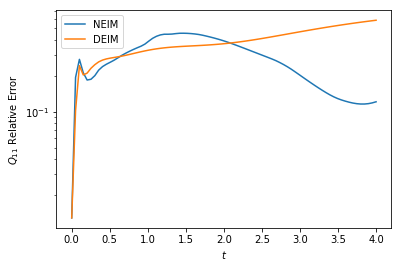

In [27]:
plt.semilogy(tVals, error_time_neim, label="NEIM")
plt.semilogy(tVals, error_time_deim, label="DEIM")
plt.xlabel("$t$")
plt.ylabel("$Q_{11}$ Relative Error")
plt.legend()
plt.show()

### Total Relative Error Over $a$

In [32]:
a_list = np.arange(-0.5, 0.55, 0.05)
error_deim = []
error_neim = []
for a in a_list:
    Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(a, neim_modes)
    error_deim.append(np.linalg.norm(Q1_ - (U_Q1 @ Q1_deim.T).T) / np.linalg.norm(Q1_))
    error_neim.append(np.linalg.norm(Q1_ - (U_Q1 @ Q1_neim.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.18it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1117.17it/s]


Relative Error (DEIM): 0.1533586323491022
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 166.49it/s]


Relative Error (NEIM): 0.11616205833764101
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.15it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2256.74it/s]


Relative Error (DEIM): 0.13105537296790654
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 540.98it/s]


Relative Error (NEIM): 0.0922554606815184
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.20it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1679.57it/s]


Relative Error (DEIM): 0.11080888918974664
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 548.49it/s]


Relative Error (NEIM): 0.08407443000982306
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.82it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1794.29it/s]


Relative Error (DEIM): 0.092572232881817
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 576.51it/s]


Relative Error (NEIM): 0.0752837720889516
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.42it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1680.67it/s]


Relative Error (DEIM): 0.07628498474964063
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 642.08it/s]


Relative Error (NEIM): 0.06660408148845981
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 101.21it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2633.31it/s]


Relative Error (DEIM): 0.061898726327401954
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 478.80it/s]


Relative Error (NEIM): 0.0639986554655848
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 102.20it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2391.35it/s]


Relative Error (DEIM): 0.049411687632736734
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 602.94it/s]


Relative Error (NEIM): 0.06519094272869536
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.29it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2257.37it/s]


Relative Error (DEIM): 0.03892330602092283
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 593.97it/s]


Relative Error (NEIM): 0.05207644046357044
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.64it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2468.19it/s]


Relative Error (DEIM): 0.030717066920665462
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 576.54it/s]


Relative Error (NEIM): 0.045691087715255
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.67it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2393.91it/s]


Relative Error (DEIM): 0.025314842755686608
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 572.33it/s]


Relative Error (NEIM): 0.044078043596557835
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 101.36it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1580.02it/s]


Relative Error (DEIM): 0.02321984164716445
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 556.36it/s]


Relative Error (NEIM): 0.04303340709195555
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 108.54it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2817.63it/s]


Relative Error (DEIM): 0.02420220080447438
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 681.06it/s]


Relative Error (NEIM): 0.04601786973851169
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.74it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1754.15it/s]


Relative Error (DEIM): 0.02720106863337176
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 622.02it/s]


Relative Error (NEIM): 0.0573515145722742
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.71it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2133.26it/s]


Relative Error (DEIM): 0.031152381311977898
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 589.45it/s]


Relative Error (NEIM): 0.06347506720020982
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.09it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2194.31it/s]


Relative Error (DEIM): 0.03540934208432492
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 552.44it/s]


Relative Error (NEIM): 0.05895917073948926
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.52it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2548.55it/s]


Relative Error (DEIM): 0.03965034336021539
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 576.51it/s]


Relative Error (NEIM): 0.058679434224474795
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.90it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2255.57it/s]


Relative Error (DEIM): 0.043728422216988985
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 598.33it/s]


Relative Error (NEIM): 0.07190995663816543
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.73it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2194.66it/s]


Relative Error (DEIM): 0.047582473912230666
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 617.30it/s]


Relative Error (NEIM): 0.06979372595123476
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 101.48it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2548.42it/s]


Relative Error (DEIM): 0.05119329252449926
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 591.26it/s]


Relative Error (NEIM): 0.07942624045461649
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.13it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2255.14it/s]


Relative Error (DEIM): 0.054562204946090605
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 576.50it/s]


Relative Error (NEIM): 0.09062438564026055
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.17it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1612.01it/s]


Relative Error (DEIM): 0.05770044316572506
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 658.32it/s]


Relative Error (NEIM): 0.08554102327958131


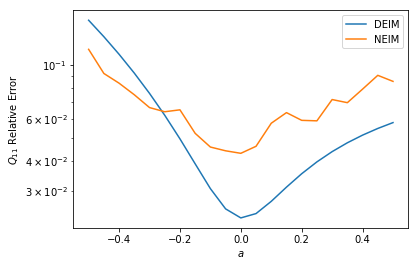

In [33]:
plt.semilogy(a_list, error_deim, label="DEIM")
plt.semilogy(a_list, error_neim, label="NEIM")
plt.xlabel("$a$")
plt.ylabel("$Q_{11}$ Relative Error")
plt.legend()
plt.show()

### DEIM-NEIM Error Contour Plots for $Q_{11}$

In [34]:
a_list = np.arange(-0.5, 0.55, 0.05)
error_deim_contour = []
error_neim_contour = []
for a in a_list:
    error_deim_contour.append([])
    error_neim_contour.append([])
    
    Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(a, neim_modes)
    
    for i, t in enumerate(tVals):
        error_deim_contour[-1].append(np.linalg.norm(Q1_[i] - (U_Q1 @ Q1_deim.T).T[i]) / np.linalg.norm(Q1_[i]))
        error_neim_contour[-1].append(np.linalg.norm(Q1_[i] - (U_Q1 @ Q1_neim.T).T[i]) / np.linalg.norm(Q1_[i]))

a_contour, time_contour = np.meshgrid(tVals, a_list)

Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 102.07it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2468.21it/s]


Relative Error (DEIM): 0.1533586323491022
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 459.30it/s]


Relative Error (NEIM): 0.11616205833764101
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 107.56it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2393.52it/s]


Relative Error (DEIM): 0.13105537296790654
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 512.87it/s]


Relative Error (NEIM): 0.0922554606815184
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.47it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2632.71it/s]


Relative Error (DEIM): 0.11080888918974664
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 631.99it/s]


Relative Error (NEIM): 0.08407443000982306
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.69it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2821.66it/s]


Relative Error (DEIM): 0.092572232881817
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 612.41it/s]


Relative Error (NEIM): 0.0752837720889516
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.83it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2633.71it/s]


Relative Error (DEIM): 0.07628498474964063
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 692.98it/s]


Relative Error (NEIM): 0.06660408148845981
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.83it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1555.79it/s]


Relative Error (DEIM): 0.061898726327401954
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 232.63it/s]


Relative Error (NEIM): 0.0639986554655848
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.30it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2724.65it/s]


Relative Error (DEIM): 0.049411687632736734
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 568.31it/s]


Relative Error (NEIM): 0.06519094272869536
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.55it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2322.90it/s]


Relative Error (DEIM): 0.03892330602092283
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 627.05it/s]


Relative Error (NEIM): 0.05207644046357044
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 109.46it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2135.59it/s]


Relative Error (DEIM): 0.030717066920665462
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 642.23it/s]


Relative Error (NEIM): 0.045691087715255
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.10it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1645.88it/s]


Relative Error (DEIM): 0.025314842755686608
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 472.59it/s]


Relative Error (NEIM): 0.044078043596557835
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.87it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2195.00it/s]


Relative Error (DEIM): 0.02321984164716445
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 556.37it/s]


Relative Error (NEIM): 0.04303340709195555
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.01it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1548.69it/s]


Relative Error (DEIM): 0.02420220080447438
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 478.76it/s]


Relative Error (NEIM): 0.04601786973851169
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.77it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2762.88it/s]


Relative Error (DEIM): 0.02720106863337176
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 624.20it/s]


Relative Error (NEIM): 0.0573515145722742
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 107.13it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2725.64it/s]


Relative Error (DEIM): 0.031152381311977898
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 636.99it/s]


Relative Error (NEIM): 0.06347506720020982
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.27it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2255.19it/s]


Relative Error (DEIM): 0.03540934208432492
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 626.97it/s]


Relative Error (NEIM): 0.05895917073948926
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 109.80it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2255.16it/s]


Relative Error (DEIM): 0.03965034336021539
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 626.84it/s]


Relative Error (NEIM): 0.058679434224474795
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.45it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2134.95it/s]


Relative Error (DEIM): 0.043728422216988985
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 576.56it/s]


Relative Error (NEIM): 0.07190995663816543
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.90it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1880.92it/s]


Relative Error (DEIM): 0.047582473912230666
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 637.10it/s]


Relative Error (NEIM): 0.06979372595123476
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.64it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1974.41it/s]


Relative Error (DEIM): 0.05119329252449926
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 501.07it/s]


Relative Error (NEIM): 0.07942624045461649
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.06it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2323.11it/s]


Relative Error (DEIM): 0.054562204946090605
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 519.67it/s]


Relative Error (NEIM): 0.09062438564026055
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.50it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2025.70it/s]


Relative Error (DEIM): 0.05770044316572506
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 589.41it/s]


Relative Error (NEIM): 0.08554102327958131


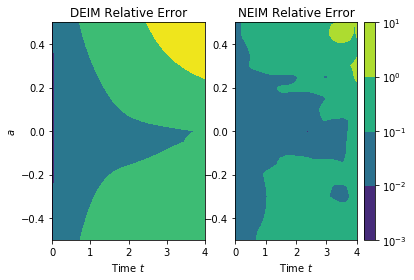

In [35]:
fig, ax = plt.subplots(1, 2)

ax[0].contourf(a_contour, time_contour, error_deim_contour, locator=ticker.LogLocator(), vmin=np.min(error_deim_contour), vmax=np.max(error_neim_contour))
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("$a$")
ax[0].set_title("DEIM Relative Error")

cs = ax[1].contourf(a_contour, time_contour, error_neim_contour, locator=ticker.LogLocator())
ax[1].set_xlabel("Time $t$")
ax[1].set_title("NEIM Relative Error")
ax[1].set_xlabel("Time $t$")
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
plt.colorbar(cs)
plt.show()

### Error in Nonlinear Term (Not Error of Solution)

In [ ]:
def solve_deim_neim_nonlinearities(a=0.):

    Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
    solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

    Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim = initialize_Q_flow_DEIM(Q1_, Q2_, p1_, p2_, r_, 
                                                                                              U_Q1, U_Q2, U_r, 
                                                                                              nQ_indices, nR_indices)
    hfQ_nonlinearities = []
    hfR_nonlinearities = []
    deimQ_nonlinearities = []
    deimR_nonlinearities = []
    neimQ_nonlinearities = []
    neimR_nonlinearities = []
    for t in range(Q1_.shape[0]-1):
        
        g1 = M * gamma * p1_[t] * r_[t]
        g2 = M * gamma * p2_[t] * r_[t]
        Q_nonlinearity = np.concatenate((g1, g2))
        R_nonlinearity = 2 * p1_[t] * (Q1_[t+1] - Q1_[t]) + 2 * p2_[t] * (Q2_[t+1] - Q2_[t])
        
        hfQ_nonlinearities.append(Q_nonlinearity)
        hfR_nonlinearities.append(R_nonlinearity)
        
        Q1_t = (U_Q1 @ U_Q1.T @ Q1_[t].reshape(-1, 1)).reshape(-1)
        Q2_t = (U_Q2 @ U_Q2.T @ Q2_[t].reshape(-1, 1)).reshape(-1)
        
        Q1_t1 = (U_Q1 @ U_Q1.T @ Q1_[t+1].reshape(-1, 1)).reshape(-1)
        Q2_t1 = (U_Q2 @ U_Q2.T @ Q2_[t+1].reshape(-1, 1)).reshape(-1)
        
        Q_t = np.concatenate((
                    np.concatenate((Q1_t[:, None, None], Q2_t[:, None, None]), axis=2),
                    np.concatenate((Q2_t[:, None, None], -Q1_t[:, None, None]), axis=2),
            ), axis=1)
        PQ = P(Q_t, a, b, c, A0)
        p1_t = PQ[:, 0, 0]
        p2_t = PQ[:, 0, 1]
        
        g1 = M * U_Q1 @ U_deimQ1 @ (gamma[nQ_indices].reshape(-1, 1) * p1_t[nQ_indices].reshape(-1, 1) * (U_r[nQ_indices] @ U_r.T @ r_[t].reshape(-1, 1)))
        g2 = M * U_Q2 @ U_deimQ2 @ (gamma[nQ_indices].reshape(-1, 1) * p2_t[nQ_indices].reshape(-1, 1) * (U_r[nQ_indices] @ U_r.T @ r_[t].reshape(-1, 1)))
    
        deimQ_nonlinearity = np.concatenate((g1.reshape(-1), g2.reshape(-1)))
        deimR_nonlinearity = (U_r @ (U_deimR @ (2*(p1_t * (Q1_t1 - Q1_t))[nR_indices].reshape(-1, 1)\
                             + 2*(p2_t * (Q2_t1 - Q2_t))[nR_indices].reshape(-1, 1)))).reshape(-1)
        
        deimQ_nonlinearities.append(deimQ_nonlinearity)
        deimR_nonlinearities.append(deimR_nonlinearity)

        with torch.no_grad():
            ro_sol = np.concatenate([U_Q1.T @ Q1_[t].reshape(-1, 1), U_Q2.T @ Q2_[t].reshape(-1, 1), U_r.T @ r_[t].reshape(-1, 1)], axis=0).reshape(-1)
            neimQ_nonlinearity = (scipy.linalg.block_diag(U_Q1, U_Q2) @ NQ_NEIM(np.array([t, a]), ro_sol).reshape(-1, 1)).reshape(-1)
            ro_sol = np.concatenate([U_Q1.T @ Q1_[t].reshape(-1, 1), U_Q1.T @ Q1_[t-1].reshape(-1, 1), 
                                     U_Q2.T @ Q2_[t].reshape(-1, 1), U_Q2.T @ Q2_[t-1].reshape(-1, 1)], axis=0).reshape(-1)
            neimR_nonlinearity = (U_r @ NR_NEIM(np.array([t-1, a]), ro_sol).reshape(-1, 1)).reshape(-1)

            neimQ_nonlinearities.append(neimQ_nonlinearity)
            neimR_nonlinearities.append(neimR_nonlinearity)
    
    hfQ_nonlinearities = np.array(hfQ_nonlinearities)
    hfR_nonlinearities = np.array(hfR_nonlinearities)
    deimQ_nonlinearities = np.array(deimQ_nonlinearities)
    deimR_nonlinearities = np.array(deimR_nonlinearities)
    neimQ_nonlinearities = np.array(neimQ_nonlinearities)
    neimR_nonlinearities = np.array(neimR_nonlinearities)
    
    return hfQ_nonlinearities, hfR_nonlinearities, deimQ_nonlinearities, deimR_nonlinearities, neimQ_nonlinearities, neimR_nonlinearities


# a_list = np.arange(-0.5, 0.55, 0.05)
# error_deim_contour = []
# error_neim_contour = []
# for a in a_list:
#     error_deim_contour.append([])
#     error_neim_contour.append([])
    
#     Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(a)
    
#     for i, t in enumerate(tVals):
#         error_deim_contour[-1].append(np.linalg.norm(Q1_[i] - (U_Q1 @ Q1_deim.T).T[i]) / np.linalg.norm(Q1_[i]))
#         error_neim_contour[-1].append(np.linalg.norm(Q1_[i] - (U_Q1 @ Q1_neim.T).T[i]) / np.linalg.norm(Q1_[i]))

# a_contour, time_contour = np.meshgrid(tVals, a_list)

In [ ]:
hfQ_nonlinearities, hfR_nonlinearities, deimQ_nonlinearities, deimR_nonlinearities, neimQ_nonlinearities, neimR_nonlinearities = solve_deim_neim_nonlinearities(a=0.15)

In [ ]:
for t in range(hfQ_nonlinearities.shape[0]):
    print("DEIM:", np.linalg.norm(hfR_nonlinearities[t] - deimR_nonlinearities[t]) / np.linalg.norm(hfR_nonlinearities[t]), "\tNEIM:", np.linalg.norm(hfR_nonlinearities[t] - neimR_nonlinearities[t]) / np.linalg.norm(hfR_nonlinearities[t]))
    print("DEIM:", np.linalg.norm(hfQ_nonlinearities[t] - deimQ_nonlinearities[t]) / np.linalg.norm(hfQ_nonlinearities[t]), "\tNEIM:", np.linalg.norm(hfQ_nonlinearities[t] - neimQ_nonlinearities[t]) / np.linalg.norm(hfQ_nonlinearities[t]))
    print("")

### Error with respect to number of modes taken

In [ ]:
f_NEIM